## Проект e-commerce. Анализ продаж

Руководство интернет-магазина предоставило несколько файлов с выгрузкой информации о продажах за период.   
Необходимо проанализировать совершенные покупки и ответить на следующие вопросы:

1.	Сколько пользователей, которые совершили покупку только один раз?  
2.	Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3.	По каждому товару определить, в какой день недели товар чаще всего покупается. 
4.	Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
5.	Когорты  
5.1.	Когортный анализ пользователей.  
5.2.	В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.   
6.	Построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

#### Файлы:  
1)	olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей  
2)	olist_orders_dataset.csv —  таблица заказов

#### План:  
1) Выгрузка и изучение имеющихся данных.   
2) Выполнение операций с данными в рамках заданий проекта.

### 1) Выгрузка и изучение имеющихся данных.   

In [1]:
import pandas as pd
import datetime as dt
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv', encoding='windows-1251')
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [3]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [4]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [5]:
items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'], encoding='windows-1251')
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [6]:
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [7]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [8]:
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], encoding='windows-1251')
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [9]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [10]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

### 2) Выполнение операций с данными в рамках заданий проекта.

#### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [11]:
activ = pd.merge(orders, customers, on='customer_id')
activ.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


In [12]:
activ.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [13]:
# В датафрейме есть колонка, содержащая сведения о том, оплачен ли заказ -  "Время подтверждения оплаты заказа" 
# ('order_approved_at'). Поскольку данная колонка имеет значения NaN, я буду ориентироваться на статус заказа. 
# При этом, хочу проанализировать, 
# нет ли противоречий между якобы оплаченными заказами на основании данных колонки 'order_approved_at' 
# и неоплаченным статусом заказа. И наоборот.

In [14]:
# Есть дата оплаты заказа, статусы:

In [15]:
activ.query('order_approved_at.notnull()').groupby('order_status', as_index=False).agg({'order_id':'count'})

,order_status,order_id
0,approved,2
1,canceled,484
2,delivered,96464
3,invoiced,314
4,processing,301
5,shipped,1107
6,unavailable,609


In [16]:
activ.query('order_approved_at.notnull() & order_status == "canceled"' )

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,8ea097b1824dbd4d17af71b0afe04301,5514,sao paulo,SP
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,c4ebedb09beb89cc0314c5c0c33f8053,9961,diadema,SP
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23,11c3d6c93dea6ce86769a4835c171bd9,87013,maringa,PR
1811,0966b61e30c4a07edbd7523f59b3f3e4,2fcc597b8934d99715dbfff7909dd27f,canceled,2018-05-22 18:50:55,2018-05-22 19:17:15,NaT,NaT,2018-07-03,da4f38e2697f8013c97ed2d8af65e0b9,28898,rio das ostras,RJ
1819,9021cf1919f615a121410790dcce848f,7acf55df0298e1d2c31200fb4f6fb93b,canceled,2018-07-04 16:05:56,2018-07-06 02:55:16,NaT,NaT,2018-08-22,54d7a15160876f86860fd741b906a742,39230,buenopolis,MG
...,...,...,...,...,...,...,...,...,...,...,...,...
98496,2be6c8b958e16856397259974d4abee9,ccbce7bcb13ee88adcf78890cae0ea42,canceled,2018-04-02 18:20:00,2018-04-02 18:30:38,NaT,NaT,2018-04-19,4e5fccc1c335360bbc4a9aac8491e477,72001,brasilia,DF
98629,f5f8998eee8ec7bc513dc52847d64ce0,f4656b824844a039a87fd9c51ad3586a,canceled,2018-03-01 11:42:23,2018-03-01 12:20:32,NaT,NaT,2018-03-20,149164aee69ed656dedbbe68623157bc,13469,americana,SP
98771,5a8a4dc28b16fb90469ad749f9535773,c0c8b8bb055100a0cc08dcc04d847ac9,canceled,2018-03-13 10:58:09,2018-03-14 03:08:35,NaT,NaT,2018-03-23,82ec5f749b66f1857e868b6414a67ab3,6765,taboao da serra,SP
98791,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30,78a159045124eb7601951b917a42034f,89111,gaspar,SC


In [17]:
# В 6 заказах заполнена Дата доставки. Остальные не доставлены.
# 6 заказов оплачены, доставлены, но имеют статус canceled. Здесь требуется уточнение. 
# Но скорее всего, данные заказы отменены по разным причинам
# (например, заказ доставлен по ошибке другому покупателю, либо не качественный товар). 

# Следовательно, колонка Статус заказа - верная.    

In [18]:
activ \
    .query('order_approved_at.notnull() & order_status in ["unavailable", "invoiced", "canceled", "approved"] & order_delivered_customer_date.notnull()') \
    .sort_values('order_delivered_carrier_date')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29,59a7bb642795ddc85534fbd5f7360334,20091,rio de janeiro,RJ
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30,2f96790fba243100730c8d1185dd2f25,5846,sao paulo,SP
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08,d93a22bb52bb2f41a7267b8a02370781,88058,florianopolis,SC
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30,f9af3bfab584769f34c314b222d34263,20091,rio de janeiro,RJ
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,b8b8726af116a5cfb35b0315ecef9172,22770,rio de janeiro,RJ
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09,6a04c8339c44b23e189446216a494569,32071,contagem,MG


In [19]:
# Отсутствует информация об оплате, но статус оплаченный:

In [20]:
activ.query('order_approved_at.isnull()').groupby('order_status', as_index=False).agg({'order_id':'count'})

,order_status,order_id
0,canceled,141
1,created,5
2,delivered,14


In [21]:
# Есть заказы в статусе Доставлен 'delivered' , но с пустым полем Даты оплаты заказа 'order_approved_at'. 
# Необходимо внимательно посмотреть на такие заказы и принять решение какому столбцу "верить".
# После разгруппировки, видно, что в доставленных заказах хотя и отсутствует дата оплаты, но заполнены поля по доставке заказа. 
# Очевидно, что доставке подлежат именно оплаченные товары. Значит колонка Статус заказа - верная.    

In [22]:
activ.query('order_approved_at.isnull() & order_status == "delivered"') 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,8a9a08c7ca8900a200d83cf838a07e0b,6708,cotia,SP
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,91efb7fcabc17925099dced52435837f,93548,novo hamburgo,RS
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,e1f01a1bd6485e58ad3c769a5427d8a8,8230,sao paulo,SP
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,7e1a5ca61b572d76b64b6688b9f96473,62700,caninde,CE
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,6ff8b0d7b35d5c945633b8d60165691b,11030,santos,SP
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,5a4fa4919cbf2b049e72be460a380e5b,35620,abaete,MG


In [23]:
# Что считать покупкой? Покупкой считаю те заказы, что уже оплачены. 
# В специализированном поле "order_approved_at" содержатся NaN. При фильтрации я буду ориентироваться на "order_status":
        # created —  создан, но НЕ оплачен
        # approved —  подтверждёно наличие товара и возможность доставки, но НЕ оплачен
        # invoiced —  выставлен счёт, заказ НЕ оплачен
        # processing —  в процессе сборки заказа, значит заказ ОПЛАЧЕН
        # shipped —  отгружен со склада. ОПЛАЧЕН
        # delivered —  доставлен пользователю. ОПЛАЧЕН
        # unavailable —  недоступен. Информации нет, заказ НЕ оплачен.
        # canceled —  отменён. Заказ либо НЕ оплачен, либо оплата возвращена

In [24]:
one_buy = activ.query('order_status in ["processing", "shipped", "delivered"]')

In [25]:
one_buy = one_buy.groupby(['customer_unique_id'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'count_orders'}).sort_values('count_orders', ascending = False)
one_buy

,customer_unique_id,count_orders
52185,8d50f5eadf50201ccdcedfb9e2ac8455,16
23125,3e43e6105506432c953e165fb2acf44c,9
74975,ca77025e7201e3b30c44b472ff346268,7
10204,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37254,6469f99c1f9dfae7733b25662e7f1782,7
...,...,...
32020,56546b71f8bf254f860014fae431af6d,1
32018,565427a96f0865bacef2a6b400197b46,1
32017,565283fe12fa1a894ef451c4bfb391ed,1
32016,5650e95cbd234d30d80befa7c4ab1618,1


In [26]:
one_buy = one_buy.query('count_orders == "1"')
one_buy

,customer_unique_id,count_orders
63343,aaf4524283dd8ca4c10416322ffcc499,1
64443,adf6e13fe35d4626f4b6654c2fa99f71,1
63294,aadb965c28e1d3e9933c689da0ee5dff,1
63303,aae296875a5380b09f3785a729183ff2,1
64461,ae00eb90b34f0bee0b8084c6a22b6fe6,1
...,...,...
32020,56546b71f8bf254f860014fae431af6d,1
32018,565427a96f0865bacef2a6b400197b46,1
32017,565283fe12fa1a894ef451c4bfb391ed,1
32016,5650e95cbd234d30d80befa7c4ab1618,1


In [27]:
# Ответ: пользователей, которые совершили покупку только один раз = 91814
num_customers = one_buy['customer_unique_id'].count()
num_customers

91814

#### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [28]:
# В датафрейме имеется колонка, содержащая сведения о дате плановой доставки товара покупателю "order_estimated_delivery_date". 
# Дата плановой доставки должна соответствовать фактической дате доставки.
# Если она не соответсвует, то речь идет о задержке доставки. 
# Если же фактическая доставка отсутствует вообще, значит мы говорим о том, 
# что товар должен был быть доставлен в плановую дату доставки, но не доставлен.
# Следовательно, на основании колонки "order_estimated_delivery_date" мы будем считать месяц НЕдоставки.

In [29]:
delivery = orders

In [30]:
delivery['month_delivery_plan'] = orders.order_estimated_delivery_date.dt.strftime('%Y-%m')

In [31]:
delivery['order_estimated_delivery_date'].isna().sum()

0

In [32]:
delivery['order_delivered_customer_date'].isna().sum()

2965

In [33]:
delivery.query('order_status != "delivered"').shape

(2963, 9)

In [34]:
# Эти заказы имеют статус Доставлен, но ещё не доставлены покупателю:
delivery.query('order_status == "delivered" & order_delivered_customer_date.isna()').shape

(8, 9)

In [35]:
# Всего не доставлены покупателю 2957 заказов:
delivery.query('order_status != "delivered" & order_delivered_customer_date.isna()').shape

(2957, 9)

In [36]:
delivery = delivery.query('order_status != "delivered" & order_delivered_customer_date.isna()')
delivery.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_delivery_plan
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-05
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,2018-08


In [37]:
delivery.shape

(2957, 9)

In [38]:
# Точное число недоставленных заказов по месяцам и причинам

In [39]:
not_delivery = delivery.groupby(['month_delivery_plan', 'order_status'], as_index=False) \
        .agg({'order_estimated_delivery_date':'count'}) \
        .rename(columns={'order_estimated_delivery_date':'count_not_delivery'}).reset_index()
not_delivery.head(10)

,index,month_delivery_plan,order_status,count_not_delivery
0,0,2016-09,canceled,1
1,1,2016-10,canceled,3
2,2,2016-10,shipped,1
3,3,2016-11,canceled,10
4,4,2016-11,invoiced,9
5,5,2016-11,shipped,1
6,6,2016-11,unavailable,5
7,7,2016-12,canceled,7
8,8,2016-12,invoiced,9
9,9,2016-12,processing,2


In [40]:
# среднее в каждом месяце:

In [41]:
mean_not_delivery = not_delivery.groupby('month_delivery_plan', as_index=False) \
    .agg({'count_not_delivery': 'mean'}) \
    .rename(columns={'count_not_delivery':'mean_not_delivery'}) \
    .round().reset_index()

In [42]:
mean_not_delivery

,index,month_delivery_plan,mean_not_delivery
0,0,2016-09,1.0
1,1,2016-10,2.0
2,2,2016-11,6.0
3,3,2016-12,5.0
4,4,2017-02,2.0
5,5,2017-03,32.0
6,6,2017-04,21.0
7,7,2017-05,22.0
8,8,2017-06,29.0
9,9,2017-07,26.0


In [43]:
not_delivery.count_not_delivery.sum()

2957

In [44]:
# среднее значение для каждой причины за весь период:

In [45]:
mean_by_reason = not_delivery \
    .groupby("order_status") \
    .agg({'count_not_delivery': 'mean'}) \
    .rename(columns={'count_not_delivery':'mean_not_delivery'}) \
    .round() \
    .sort_values('mean_not_delivery', ascending=False)
mean_by_reason

,mean_not_delivery
order_status,
shipped,48.0
unavailable,29.0
canceled,24.0
processing,16.0
invoiced,15.0
created,2.0
approved,1.0


#### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [46]:
order_item = pd.merge(items, orders, on='order_id')
order_item

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_delivery_plan
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-05
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-02
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,2018-05
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,2018-08
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,2017-11
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,2017-08


In [47]:
order_item.isna().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
month_delivery_plan                 0
dtype: int64

In [48]:
order_item['weeks_day'] = order_item.order_purchase_timestamp.dt.day_name()

In [49]:
order_item_activ = order_item.query('order_status in ["processing", "shipped", "delivered"]')

In [50]:
order_item_activ

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_delivery_plan,weeks_day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-05,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-02,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-03,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,2018-05,Monday
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,2018-08,Saturday
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,2017-11,Monday
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,2017-08,Monday


In [51]:
duplicateRows = order_item_activ[order_item_activ.duplicated()]

In [52]:
duplicateRows

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_delivery_plan,weeks_day


In [53]:
# Полных дупликатов нет, но есть случаи, когда в одном заказе три одинаковых товара. 
# Считаю, что такие случаи должны учитываться в подсчете, т.к. это влияет на частоту заказа товара, что нам и требуется узнать.

In [54]:
order_item_activ.query('order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_delivery_plan,weeks_day
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,2017-11,Monday
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,2017-11,Monday
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06,2017-11,Monday


In [55]:
week = order_item_activ \
    .groupby(['product_id', 'weeks_day'], as_index=False) \
    .agg({'order_status': 'count'}) \
    .rename(columns={'order_status':'count'}) \
    .sort_values('count', ascending=False)
week

,product_id,weeks_day,count
15766,422879e10f46682990de24d770e7f83d,Wednesday,93
36178,99a4788cb24856965c36a24e339b6058,Monday,92
40679,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40675,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
40680,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
23813,64367bed3ed96fd9381676fbe33b6443,Sunday,1
23814,643a4049ae3e6df63858575f28cd7b21,Friday,1
23815,643a4049ae3e6df63858575f28cd7b21,Sunday,1
23816,643a66b1dc5dad3de6cb5a41549e72f1,Sunday,1


In [56]:
# Если мы хотим видеть только одну строчку товара с самым частым значением, то повторяющиеся товары можно удалить

In [57]:
week.drop_duplicates(subset='product_id')

,product_id,weeks_day,count
15766,422879e10f46682990de24d770e7f83d,Wednesday,93
36178,99a4788cb24856965c36a24e339b6058,Monday,92
40679,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19944,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13422,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
23811,6435be64ad92f52631170f9a92718a99,Sunday,1
23813,64367bed3ed96fd9381676fbe33b6443,Sunday,1
23814,643a4049ae3e6df63858575f28cd7b21,Friday,1
23816,643a66b1dc5dad3de6cb5a41549e72f1,Sunday,1


#### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [58]:
# Не стоит забывать, что внутри месяца может быть не целое количество недель. 
# Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [59]:
# Возвращаюсь к таблице на первом шагу, заказы + покупатели. ЕЕ буду преобразовывать

In [60]:
activ

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [61]:
buy = activ[['order_id', 'order_status', 'customer_unique_id', 'order_purchase_timestamp']]
buy

,order_id,order_status,customer_unique_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39
...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,delivered,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05
99437,63943bddc261676b46f01ca7ac2f7bd8,delivered,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,delivered,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43
99439,11c177c8e97725db2631073c19f07b62,delivered,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27


In [62]:
buy['date'] = pd.to_datetime(activ.order_purchase_timestamp.dt.strftime('%d-%m-%Y'))
buy['year'] = (activ.order_purchase_timestamp.dt.strftime('%Y')).astype(int)
buy['month'] = (activ.order_purchase_timestamp.dt.strftime('%m')).astype(int)


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [63]:
buy['week'] = buy['date'].dt.week

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
buy.dtypes

order_id                            object
order_status                        object
customer_unique_id                  object
order_purchase_timestamp    datetime64[ns]
date                        datetime64[ns]
year                                 int64
month                                int64
week                                 int64
dtype: object

In [65]:
buy['count_days'] = buy.apply(lambda row: calendar.monthrange(row['year'], row['month'])[1], axis=1)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
buy

,order_id,order_status,customer_unique_id,order_purchase_timestamp,date,year,month,week,count_days
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-02-10,2017,10,6,31
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-24,2018,7,30,31
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08,2018,8,32,31
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18,2017,11,46,30
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13,2018,2,7,28
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,delivered,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,2017-09-03,2017,3,35,31
99437,63943bddc261676b46f01ca7ac2f7bd8,delivered,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-06-02,2018,2,22,28
99438,83c1379a015df1e13d02aae0204711ab,delivered,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08-27,2017,8,34,31
99439,11c177c8e97725db2631073c19f07b62,delivered,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-08-01,2018,1,31,31


In [67]:
buy = buy.query('order_status in ["processing", "shipped", "delivered"]')

In [68]:
buy_week = buy.groupby(['customer_unique_id', 'week'], as_index=False).agg({'order_id':'count'}) \
        .rename(columns={'order_id': 'count_order_week'}).sort_values(['count_order_week'], ascending=False)

In [69]:
buy_week

,customer_unique_id,week,count_order_week
7233,12f5d6e1cbf93dafd9dcc19095df0b3d,18,6
50017,83e7958a94bd7f74a9414d8782f87628,18,4
68579,b4e4f24de1e8725b74e4a1f4975116ed,8,4
26766,46958f708ade6b6a88b2e5aca1e66de5,35,3
80232,d3882d7abd0c66064d740d7ed04dd1ef,7,3
...,...,...,...
32426,557b75f940a01e7ba17ffbf9cc02bb9b,31,1
32425,557b158701bedbb76b856eb5f3af51b1,44,1
32424,557b158701bedbb76b856eb5f3af51b1,13,1
32423,55793e34e09ee9b1ff6cfdc7398257dd,49,1


In [70]:
buy_week.groupby(['customer_unique_id'], as_index=False).agg({'count_order_week':'mean'}) \
        .rename(columns={'count_order_week': 'mean_order_week'}).sort_values(['mean_order_week'], ascending=False)

,customer_unique_id,mean_order_week
7074,12f5d6e1cbf93dafd9dcc19095df0b3d,6.0
48896,83e7958a94bd7f74a9414d8782f87628,4.0
67519,b64ebaf3d11b7209fe566364cc359a51,3.0
2457,06a52782a04f0086d16b9c22d0e29438,3.0
85767,e78838df9c44e102b6ac84cc5eea7d5c,3.0
...,...,...
31690,556cf877ff4c70e71e97a35057f6ed23,1.0
31689,556b9d9fe41bf7a26e0d1c177ff832d8,1.0
31688,556b7a1c51bfef61bde3ab5d03f850b4,1.0
31687,556b4e56ead59462cd4d817f58d5a5ce,1.0


In [71]:
# Ответ на задачу представлен выше. 

#### 5. Когортный анализ пользователей. 
В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

In [72]:
# Для дальнейшего преобразования использую старую таблицу, полученную соединением талицы заказов и покупателей. 
# Ранее я выяснила, что покупками мы считаем заказы с 3 статусами.
formula = activ.query('order_status in ["processing", "shipped", "delivered"]')
formula

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [73]:
#Создаю колонку с датой первой покупки. Даты покупок я буду брать в столбце, содержащем время создания заказа, 
# предварительно отфильтровав по статусу. Другой столбец order_approved_at , содержащий дату оплаты покупки, 
# имеет пустые значения и противоречит статусам заказа. Данное обстоятельство я также выясняла на более ранних шагах.

In [74]:
formula['first_order'] = formula.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
#преобразую даты к месяцам, т.к. нас интересуют данные в разрезе месяца
formula['first_order'] = pd.to_datetime(formula.first_order.dt.strftime('%m-%Y'))
formula['order_purchase_timestamp'] = pd.to_datetime(formula.order_purchase_timestamp.dt.strftime('%m-%Y'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
formula.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,first_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-01,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-01,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-01,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08-01


In [77]:
cogort_tabl = formula.query('first_order >= "2017-01-01" & first_order <= "2017-12-01"') \
     .groupby(['first_order', 'order_purchase_timestamp'], as_index=False) \
     .agg({'customer_unique_id':'nunique'})
cogort_tabl

,first_order,order_purchase_timestamp,customer_unique_id
0,2017-01-01,2017-01-01,740
1,2017-01-01,2017-02-01,3
2,2017-01-01,2017-03-01,2
3,2017-01-01,2017-04-01,1
4,2017-01-01,2017-05-01,3
...,...,...,...
166,2017-12-01,2018-04-01,14
167,2017-12-01,2018-05-01,11
168,2017-12-01,2018-06-01,9
169,2017-12-01,2018-07-01,1


In [78]:
cogort_tabl['per'] = ((cogort_tabl.order_purchase_timestamp - cogort_tabl.first_order).dt.days/30.42).round(0)
#считаем месяц покупки, начинаем с нулевого - месяц первой покупки
cogort_tabl

,first_order,order_purchase_timestamp,customer_unique_id,per
0,2017-01-01,2017-01-01,740,0.0
1,2017-01-01,2017-02-01,3,1.0
2,2017-01-01,2017-03-01,2,2.0
3,2017-01-01,2017-04-01,1,3.0
4,2017-01-01,2017-05-01,3,4.0
...,...,...,...,...
166,2017-12-01,2018-04-01,14,4.0
167,2017-12-01,2018-05-01,11,5.0
168,2017-12-01,2018-06-01,9,6.0
169,2017-12-01,2018-07-01,1,7.0


In [79]:
cogort_tabl['per'] = cogort_tabl['per'].astype(int)

In [80]:
cogort_tabl.dtypes

first_order                 datetime64[ns]
order_purchase_timestamp    datetime64[ns]
customer_unique_id                   int64
per                                  int64
dtype: object

In [81]:
cogort_tabl = cogort_tabl.pivot(index='first_order', columns = 'per', values = 'customer_unique_id').fillna(0).reset_index()
cogort_tabl

per,first_order,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
0,2017-01-01,740.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
1,2017-02-01,1678.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,0.0
2,2017-03-01,2568.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,9.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,0.0
3,2017-04-01,2310.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,0.0,0.0
4,2017-05-01,3525.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,8.0,0.0,0.0,0.0
5,2017-06-01,3094.0,14.0,11.0,12.0,8.0,11.0,11.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,0.0,0.0,0.0,0.0
6,2017-07-01,3815.0,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0
7,2017-08-01,4112.0,28.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2017-09-01,4060.0,28.0,22.0,12.0,18.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2017-10-01,4378.0,31.0,11.0,4.0,10.0,9.0,9.0,16.0,12.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
cogort_tabl.columns

Index(['first_order', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
       17, 19],
      dtype='object', name='per')

In [83]:
# ищу максимальный retension
cogort_tabl[cogort_tabl[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
       17, 19]] == 3].iloc[:, 1:].idxmax().values[0] 
# результат ничего нам не говорит

nan

In [84]:
# Попробую по другому взглянуть на данные в когортной таблице. Сформирую диаграмму

In [85]:
# Для более читабельного вида диаграммы, удалю один столбец. Т.к. он перетягивал бы на себя все цветовые выделения
cogort_tabl = cogort_tabl.drop(0, axis=1)

Text(0.5, 1.0, 'Retention Cohort Table')

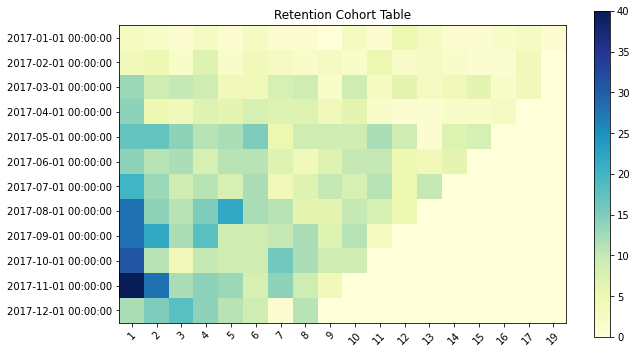

In [86]:
# Установка размера графика
plt.figure(figsize=(10, 6))
# Создание тепловой карты (heatmap)
heatmap = plt.imshow(cogort_tabl.iloc[:, 1:].values, cmap='YlGnBu')
# Добавление цветовой шкалы
plt.colorbar(heatmap)
# Добавление подписей осей
plt.xticks(range(len(cogort_tabl.columns[1:])), cogort_tabl.columns[1:], rotation=45)
plt.yticks(range(len(cogort_tabl)), cogort_tabl['first_order'])

# Добавление заголовка
plt.title('Retention Cohort Table')


In [87]:
# Темные области на диаграмме в первые месяцы Retention мы не учитываем , тк.к нас интересует максимальный Retention, 
# начиная с 3 месяца. 
# В таком случае на диаграме выделяется область на перечечении '2017-08-01' по оси у и пятым месяцем по оси х.
# Ответ: 5 

#### 6. Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

In [88]:
# В кластеризации можно выбрать следующие метрики: 
#     R - время от последней покупки пользователя до текущей даты, 
#     F - суммарное количество покупок у пользователя за всё время, 
#     M - сумма покупок за всё время. 

In [89]:
segment = pd.merge(activ, items, on='order_id') 
#создадию датасет для задачи

In [90]:
# Мы определилась на первых шагах проекта , что покупкой мы считаем заказы с определенными статусами. 
# Даты берем в столбце оформления заказа

In [91]:
segment = segment.query('order_status in ["processing", "shipped", "delivered"]').dropna()

In [92]:
segment.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
dtype: object

In [93]:
last_day = segment.order_purchase_timestamp.max()
last_day

Timestamp('2018-08-29 15:00:37')

In [96]:
today = pd.Timestamp.today().date()
today  

datetime.date(2024, 3, 27)

In [97]:
# Таблица RFM. 
# R - время от последней покупки пользователя до текущей даты 
# F - суммарное количество покупок у пользователя за всё время 
# M - стоимость покупок за всё время

In [98]:
today = pd.Timestamp.today().date() 
RFM = segment \
    .groupby('customer_unique_id') \
    .agg({'order_purchase_timestamp': lambda x: (pd.Timestamp(today) - x.max()).days,  
          'product_id': lambda x: len(x), 
          'price': lambda x: x.sum()}) \
    .rename(columns={'order_purchase_timestamp': 'R', 'product_id': 'F', 'price': 'M'})

In [99]:
RFM

,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,2147,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,2150,1,18.90
0000f46a3911fa3c0805444483337064,2573,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,2357,1,25.99
0004aac84e0df4da2b147fca70cf8255,2324,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2483,2,1570.00
fffea47cd6d3cc0a88bd621562a9d061,2298,1,64.89
ffff371b4d645b6ecea244b27531430a,2604,1,89.90


In [100]:
# диапазон от 1 до 5: до 20, 20-40, 40-60, 60-80 и выше 80 %

In [101]:
RFM_seg = RFM.quantile(q=[0.20, 0.40, 0.60, 0.80]).to_dict()

In [102]:
def to_get_seg (a,b,c):
    if a <= c[b][0.20]:
        return 1
    elif a <= c[b][0.40]:
        return 2
    elif a <= c[b][0.60]:
        return 3
    elif a <= c[b][0.80]:
        return 4
    else:
        return 5

In [103]:
RFM['R_seg'] = RFM['R'].apply(to_get_seg, args=('R', RFM_seg, ))
RFM['F_seg'] = RFM['F'].apply(to_get_seg, args=('F', RFM_seg, ))
RFM['M_seg'] = RFM['M'].apply(to_get_seg, args=('M', RFM_seg, ))

In [104]:
RFM['RFMseg'] = RFM.R_seg.map(str) + RFM.F_seg.map(str) + RFM.M_seg.map(str)
RFM.sort_values('RFMseg', ascending=False)

,R,F,M,R_seg,F_seg,M_seg,RFMseg
customer_unique_id,,,,,,,
161b2eb506dd664bb5d23dc701a14b59,2442,2,258.90,5,5,5,555
f1307ff953946c8240a15b140d05a901,2421,2,238.00,5,5,5,555
cff2e70f7fd43f570fd3ba208bef731e,2463,2,207.97,5,5,5,555
401a006331c06b4b0c8830f87c13eb6a,2442,4,679.76,5,5,5,555
5334612ff6f9f1ee518ecf5a8b2d9efc,2518,2,186.00,5,5,5,555
...,...,...,...,...,...,...,...
82074615719ce97461e51ac9bf3dbbb4,2096,1,33.00,1,1,1,111
81fa4f32f696bddc27c57147b94dc3aa,2117,1,30.90,1,1,1,111
60863e9f13562f664b73e6f76ff85910,2062,1,29.00,1,1,1,111


In [105]:
# Ответ: 
# Самые выгодные покупатели те, что имеют больше всего баллов RFMseg. : 555 
# 111 — самые не выгодные, имеют всего 1 покупку. 